**Workflow**

- Initial data exploration
- Removal of columns and rows (redundant and those with a high number of NaNs)
- Outlier imputation
- Missing value imputation
- Splitting the dataset into training and validation sets
- Balancing data using SMOTE
- Standardization and PCA
- Model training with regularization
- Results evaluation
- Prediction on the test set

**Environment setup**

In [39]:
# importing libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, conv, when, trim
from pyspark.sql.types import IntegerType, LongType
from IPython.display import display
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator 
from pyspark.ml import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
# spark.stop()

In [3]:
# building spark session
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.driver.memory", "30g") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.local.dir", "/tmp/spark-temp") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.3") \
    .config("spark.sql.shuffle.partitions", "128") \
    .getOrCreate()
spark

In [9]:
# columns = ["Label", "I1", "I2", "I3", "I4", "I5", "I6", "I7", "I8", "I9", 
#            "I10", "I11", "I12", "I13", "C1", "C2", "C3", "C4", "C5", "C6", 
#            "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14", "C15", "C16", 
#            "C17", "C18", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26"]

# df = (
#     spark.read
#     .option("sep", "\t") 
#     .option("inferSchema", "true")  
#     .csv("../Dane/criteo-dataset/dac/train.txt") 
#     # "D:\coding\Kamila\Dane\criteo-dataset\dac\train.txt"
#     #work/Dane/criteo-dataset/dac/train.txt
# )

# df = df.toDF(*columns)

# df.printSchema()

root
 |-- Label: integer (nullable = true)
 |-- I1: integer (nullable = true)
 |-- I2: integer (nullable = true)
 |-- I3: integer (nullable = true)
 |-- I4: integer (nullable = true)
 |-- I5: integer (nullable = true)
 |-- I6: integer (nullable = true)
 |-- I7: integer (nullable = true)
 |-- I8: integer (nullable = true)
 |-- I9: integer (nullable = true)
 |-- I10: integer (nullable = true)
 |-- I11: integer (nullable = true)
 |-- I12: integer (nullable = true)
 |-- I13: integer (nullable = true)
 |-- C1: string (nullable = true)
 |-- C2: string (nullable = true)
 |-- C3: string (nullable = true)
 |-- C4: string (nullable = true)
 |-- C5: string (nullable = true)
 |-- C6: string (nullable = true)
 |-- C7: string (nullable = true)
 |-- C8: string (nullable = true)
 |-- C9: string (nullable = true)
 |-- C10: string (nullable = true)
 |-- C11: string (nullable = true)
 |-- C12: string (nullable = true)
 |-- C13: string (nullable = true)
 |-- C14: string (nullable = true)
 |-- C15: string 

In [10]:
# df.write.mode("overwrite").parquet("output_parquet")

In [52]:
# conversion to parquet format with given limit

# limit = 2000000
data = spark.read.parquet("output_parquet")
data = data.repartition(64) # podział na partycje żeby przyspieszyć


# display the first few rows of the data
# dataPd = data.sample(fraction=0.05)
# dataPd = dataPd.toPandas()
# dataPd.head()

In [6]:
print("Number of rows:")
print(data.count())

print("\nColumn Names:")
print(data.columns)

Number of rows:
45840617

Column Names:
['Label', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26']


**Initial data exploration**

In [27]:
# missing values

number_of_rows = data.count()

for column in data.columns:
    count_null = data.filter(col(column).isNull()).count()
    percentage_null = (count_null / number_of_rows) * 100
    print(f"Column '{column}' has {percentage_null:.2f}% NULL values.")

Column 'Label' has 0.00% NULL values.
Column 'I1' has 45.41% NULL values.
Column 'I2' has 0.00% NULL values.
Column 'I3' has 21.39% NULL values.
Column 'I4' has 21.66% NULL values.
Column 'I5' has 2.58% NULL values.
Column 'I6' has 22.38% NULL values.
Column 'I7' has 4.31% NULL values.
Column 'I8' has 0.05% NULL values.
Column 'I9' has 4.31% NULL values.
Column 'I10' has 45.41% NULL values.
Column 'I11' has 4.31% NULL values.
Column 'I12' has 76.47% NULL values.
Column 'I13' has 21.66% NULL values.
Column 'C1' has 0.00% NULL values.
Column 'C2' has 0.00% NULL values.
Column 'C3' has 3.40% NULL values.
Column 'C4' has 3.40% NULL values.
Column 'C5' has 0.00% NULL values.
Column 'C6' has 12.06% NULL values.
Column 'C7' has 0.00% NULL values.
Column 'C8' has 0.00% NULL values.
Column 'C9' has 0.00% NULL values.
Column 'C10' has 0.00% NULL values.
Column 'C11' has 0.00% NULL values.
Column 'C12' has 3.40% NULL values.
Column 'C13' has 0.00% NULL values.
Column 'C14' has 0.00% NULL values.


In [7]:
# outliers

numeric_cols = [col_name for col_name, dtype in data.dtypes if dtype in ("int", "double", "float")]
stat_list = []
for col in numeric_cols:
    stat_list.append(F.min(col).alias(f"{col}_min"))
    stat_list.append(F.max(col).alias(f"{col}_max"))
    stat_list.append(F.avg(col).alias(f"{col}_avg"))
    stat_list.append(F.stddev(col).alias(f"{col}_std"))

summary_stats = data.select(*stat_list)

Column 'Label': 2 unique values
Column 'I1': 648 unique values
Column 'I2': 9364 unique values
Column 'I3': 14745 unique values
Column 'I4': 489 unique values
Column 'I5': 476706 unique values
Column 'I6': 11617 unique values
Column 'I7': 4141 unique values
Column 'I8': 1372 unique values
Column 'I9': 7274 unique values
Column 'I10': 12 unique values
Column 'I11': 168 unique values
Column 'I12': 406 unique values
Column 'I13': 1375 unique values
Column 'C1': 1460 unique values
Column 'C2': 583 unique values
Column 'C3': 10131226 unique values
Column 'C4': 2202607 unique values
Column 'C5': 305 unique values
Column 'C6': 23 unique values
Column 'C7': 12517 unique values
Column 'C8': 633 unique values
Column 'C9': 3 unique values
Column 'C10': 93145 unique values
Column 'C11': 5683 unique values
Column 'C12': 8351592 unique values
Column 'C13': 3194 unique values
Column 'C14': 27 unique values
Column 'C15': 14992 unique values
Column 'C16': 5461305 unique values
Column 'C17': 10 unique v

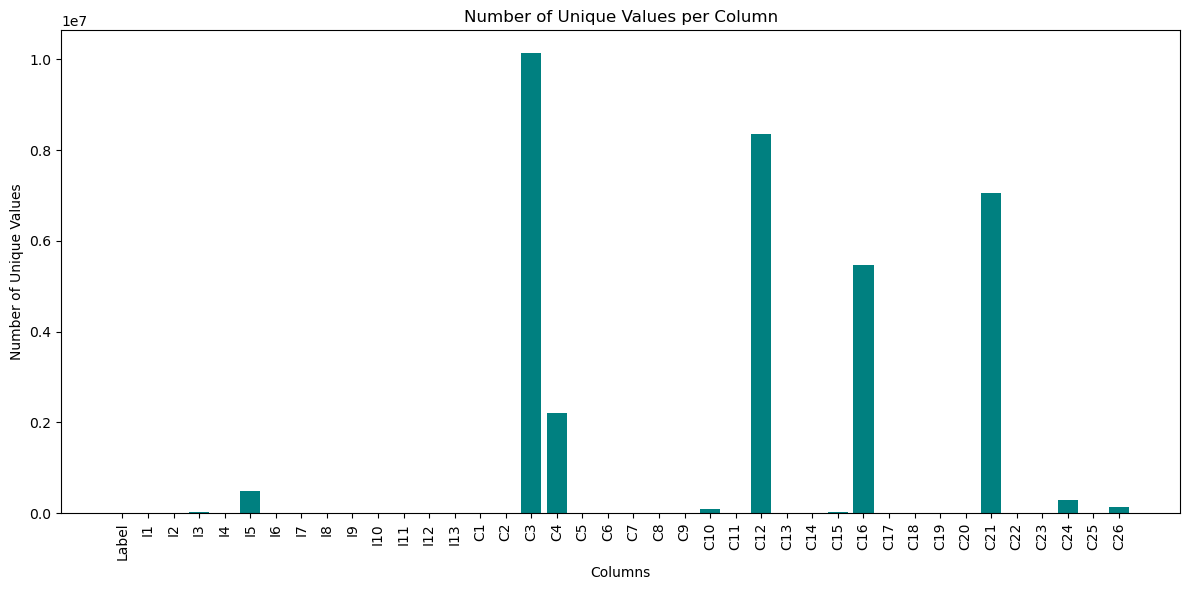

In [9]:
# cardinality of the features

unique_counts = []

for column in data.columns:
    unique_count = data.select(F.countDistinct(F.col(column))).collect()[0][0]  
    unique_counts.append((column, unique_count))
    print(f"Column '{column}': {unique_count} unique values")

unique_counts_df = pd.DataFrame(unique_counts, columns=['Column', 'Unique Count'])

plt.figure(figsize=(12, 6))
plt.bar(unique_counts_df['Column'], unique_counts_df['Unique Count'], color='teal')
plt.xticks(rotation=90)  
plt.xlabel('Columns')
plt.ylabel('Number of Unique Values')
plt.title('Number of Unique Values per Column')
plt.tight_layout()
plt.show()

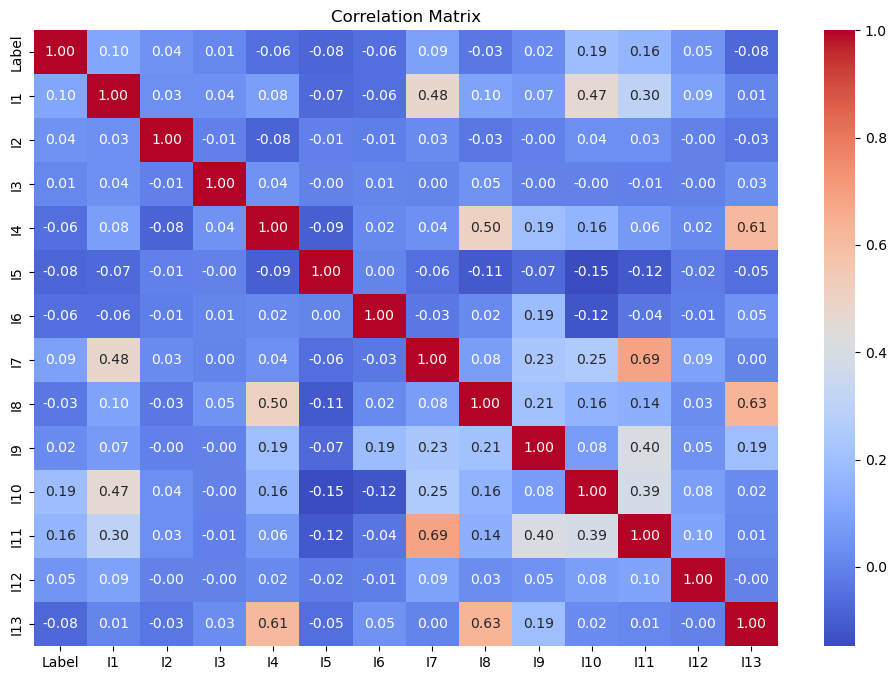

In [10]:
# correlation matrix

numeric_cols = [col_name for col_name, dtype in data.dtypes if dtype in ("int", "double", "float")]

correlation_matrix = pd.DataFrame(columns=numeric_cols, index=numeric_cols)

for col1 in numeric_cols:
    for col2 in numeric_cols:
        correlation_matrix.loc[col1, col2] = data.stat.corr(col1, col2) 

correlation_matrix = correlation_matrix.astype(float)  

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

**Converting hexadecimal values to decimal numbers**

In [53]:
def convert_hex_to_num(df):
    for column in df.columns:
        if dict(df.dtypes)[column] == 'string':
            df = df.withColumn(
                column,
                F.when(
                    F.trim(F.col(column)).rlike('^[0-9A-Fa-f]+$'),
                    F.conv(F.trim(F.col(column)), 16, 10).cast(LongType())
                ).otherwise(None)
            )
    return df

In [54]:
data = convert_hex_to_num(data)
data.printSchema()

root
 |-- Label: integer (nullable = true)
 |-- I1: integer (nullable = true)
 |-- I2: integer (nullable = true)
 |-- I3: integer (nullable = true)
 |-- I4: integer (nullable = true)
 |-- I5: integer (nullable = true)
 |-- I6: integer (nullable = true)
 |-- I7: integer (nullable = true)
 |-- I8: integer (nullable = true)
 |-- I9: integer (nullable = true)
 |-- I10: integer (nullable = true)
 |-- I11: integer (nullable = true)
 |-- I12: integer (nullable = true)
 |-- I13: integer (nullable = true)
 |-- C1: long (nullable = true)
 |-- C2: long (nullable = true)
 |-- C3: long (nullable = true)
 |-- C4: long (nullable = true)
 |-- C5: long (nullable = true)
 |-- C6: long (nullable = true)
 |-- C7: long (nullable = true)
 |-- C8: long (nullable = true)
 |-- C9: long (nullable = true)
 |-- C10: long (nullable = true)
 |-- C11: long (nullable = true)
 |-- C12: long (nullable = true)
 |-- C13: long (nullable = true)
 |-- C14: long (nullable = true)
 |-- C15: long (nullable = true)
 |-- C16: lo

**Removal of columns and rows (redundant and those with a high number of NaNs)**

In [14]:
columns_to_drop = ['I12', 'C22']
columns_strongly_correlated = ['I3', 'I8', 'I9']

In [15]:
columns_to_drop_all = columns_to_drop + columns_strongly_correlated 
data_cleaned = data.drop(*columns_to_drop_all)
data_cleaned = data_cleaned.na.drop(how="all")
print(data_cleaned.columns)

['Label', 'I1', 'I2', 'I4', 'I5', 'I6', 'I7', 'I10', 'I11', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26']


**Outlier imputation**

In [16]:
def handle_outliers(df, numeric_cols, method="iqr", action="cap", z_thresh=3.0, iqr_multiplier=1.5, threshold_ratio=0.2):
    updated_df = df

    for col in numeric_cols:
        stats = df.selectExpr(
            f'percentile({col}, array(0.25, 0.5, 0.75)) as percentiles',
            f'mean({col}) as mean',
            f'stddev({col}) as stddev'
        ).first()

        q1, median, q3 = stats['percentiles']
        mean, stddev = stats['mean'], stats['stddev']
        iqr = q3 - q1
        lower_iqr, upper_iqr = q1 - iqr_multiplier * iqr, q3 + iqr_multiplier * iqr
        lower_z, upper_z = mean - z_thresh * stddev, mean + z_thresh * stddev

        lower, upper = (lower_iqr, upper_iqr) if method == "iqr" else (lower_z, upper_z)

        total_count = df.filter(F.col(col).isNotNull()).count()
        outlier_count = df.filter((F.col(col) < lower) | (F.col(col) > upper)).count()
        outlier_ratio = outlier_count / total_count if total_count else 0

        if outlier_ratio == 0:
            continue

        if outlier_ratio > threshold_ratio:
            print(f"Skipping {col} due to high outlier ratio.")
            continue

        if action == "remove":
            updated_df = updated_df.filter((F.col(col) >= lower) & (F.col(col) <= upper))
        elif action == "impute":
            updated_df = updated_df.withColumn(
                col,
                F.when((F.col(col) < lower) | (F.col(col) > upper), median).otherwise(F.col(col))
            )
        elif action == "cap":
            updated_df = updated_df.withColumn(
                col,
                F.when(F.col(col) < lower, lower)
                 .when(F.col(col) > upper, upper)
                 .otherwise(F.col(col))
            )
        else:
            raise ValueError("Invalid action: choose from 'cap', 'remove', 'impute'.")

    return updated_df

def generate_outlier_handling_datasets(df, numeric_cols):
    # methods = ["iqr", "z-score"]
    # actions = ["cap", "remove", "impute"]
    methods = ["iqr"]
    actions = ["cap"]

    results = {}
    
    for method in methods:
        for action in actions:
            print(f"\nMethod: {method.upper()}, Action: {action.upper()}")
            handled_df = handle_outliers(
                df=df,
                numeric_cols=numeric_cols,
                method=method,
                action=action,
                z_thresh=3.0,
                iqr_multiplier=1.5,
                threshold_ratio=0.2
            )
            label = f"{method}_{action}"
            results[label] = handled_df
            # display_summary(handled_df, f"After Outlier Handling - Method: {method.upper()}, Action: {action.upper()}")

    return results

In [17]:
numeric_cols = [col_name for col_name, dtype in data_cleaned.dtypes if dtype in ("int", "double", "float")]
# report_outliers_dual(data_cleaned, numeric_cols)

data_no_outliers = generate_outlier_handling_datasets(data_cleaned, numeric_cols)


Method: IQR, Action: CAP


**Imputation of missing values**

In [19]:
def get_mode(df, column):
    mode_df = df.groupBy(column).count().orderBy(F.desc("count"))
    if mode_df.filter(F.col(column).isNotNull()).count() > 0:
        return mode_df.filter(F.col(column).isNotNull()).first()[column]
    return None

def impute_all_datasets(modified_versions, columns_to_imputate_rand):
    results = {}

    for name, df in modified_versions.items():
        print(f"\n--- Imputing Dataset: {name} ---")
        current_df = df

        existing_columns = set(current_df.columns)
        numeric_columns = [col for col in columns_to_imputate_rand if col.startswith('I') and col in existing_columns]
        categorical_columns = [col for col in columns_to_imputate_rand if col.startswith('C') and col in existing_columns]

        modes = {col: get_mode(current_df, col) for col in categorical_columns}

        # Fill categorical columns
        for col in categorical_columns:
            if modes[col] is not None:
                current_df = current_df.withColumn(
                    col, 
                    F.when(F.col(col).isNull(), modes[col]).otherwise(F.col(col))
                )

        # Apply median imputation to numeric columns
        if numeric_columns:
            imputer = Imputer(
                inputCols=numeric_columns,
                outputCols=numeric_columns,
                strategy="median"
            )
            imputer_model = imputer.fit(current_df)
            current_df = imputer_model.transform(current_df)

        # Final null check
        for col in columns_to_imputate_rand:
            if col in current_df.columns and current_df.filter(F.col(col).isNull()).count() > 0:
                print(f"Column {col} in {name} still has NULL values!")

        results[name] = current_df

    return results

In [20]:
columns_to_imputate = ['I1', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I13', 'C3', 'C4', 'C6', 'C12', 'C16', 'C19', 'C20', 'C21', 'C24', 'C25', 'C26']

data_no_missing_values= impute_all_datasets(data_no_outliers, columns_to_imputate)


--- Imputing Dataset: iqr_cap ---


In [23]:
# final dataset
print("Number of rows:")
print(data_no_missing_values["iqr_cap"].count())

print("\nColumn Names:")
print(data_no_missing_values["iqr_cap"].columns)


Number of rows:
45840617

Column Names:
['Label', 'I1', 'I2', 'I4', 'I5', 'I6', 'I7', 'I10', 'I11', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26']


In [24]:
# saving the cleaned dataset to parquet format
data_no_missing_values["iqr_cap"].write.mode("overwrite").parquet("dataset_no_missing_values45mln")

In [30]:
# loading the cleaned dataset from parquet format
data_no_missing_values = spark.read.parquet("dataset_no_missing_values45mln")

# displaying the first few rows of the cleaned dataset
data_no_missing_values.limit(5).toPandas()

,Label,I1,I2,I4,I5,I6,I7,I10,I11,I13,...,C16,C17,C18,C19,C20,C21,C23,C24,C25,C26
0,0,1.0,41.0,8.0,24835.5,33.0,0.0,1.0,0.0,8.0,...,3326956687,3854202482,1674427169,3482969566,1480633834,1603629696,974593739,395552808,3904386055,3084501948
1,0,1.0,47.0,4.0,12.0,10.0,9.0,1.0,6.0,4.0,...,3944075614,3854202482,2130030586,568184265,2757290579,3267926549,974593739,68915747,2045441,105928817
2,0,1.0,87.5,5.0,24835.5,173.0,26.0,1.0,4.0,5.0,...,2270798553,2399067775,2533528937,568184265,2972002973,1858256119,851920782,2137549491,737579441,4184459285
3,1,5.0,1.0,22.0,1.0,0.0,26.0,1.0,4.0,0.0,...,3661896830,3854202482,6055744,568184265,1480633834,2266491399,1440560485,395552808,3904386055,3112211828
4,0,0.0,0.0,5.0,10.0,74.0,26.0,0.0,6.0,1.0,...,3631376890,2399067775,1538452622,105848704,2757290579,1884071936,851920782,3158215338,4042541533,2773058801


In [31]:
train_data, val_data = data_no_missing_values.randomSplit([0.8, 0.2], seed=42)
# train_data_pd = train_data.toPandas()

X_train = train_data.drop('Label')
y_train = train_data.select('Label')

# X_train_pd = train_data_pd.drop(columns= ['Label'])
# y_train_pd = train_data_pd['Label']

**Standardization and PCA**

In [32]:
numeric_cols = [col for col in train_data.columns if col != "Label"]  
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")


scaler = StandardScaler(inputCol="features", 
                             outputCol="scaledFeatures",
                             withStd=True, 
                             withMean=True)

In [33]:
pipeline_pca = Pipeline(stages=[assembler, scaler])
scaler_model = pipeline_pca.fit(train_data) 
scaled_data= scaler_model.transform(train_data) 

In [34]:
num_features = len(numeric_cols)
pca_model_selection= PCA(k=num_features, inputCol="scaledFeatures", outputCol="pcaFeatures").fit(scaled_data)

explained_variance = pca_model_selection.explainedVariance
cumulative_variance = []
total_variance = 0.0
for variance in explained_variance:
    total_variance += float(variance)
    cumulative_variance.append(total_variance)

In [35]:
print(len(cumulative_variance))

34


In [36]:
best_k = next(i + 1 for i, cum_var in enumerate(cumulative_variance) if cum_var >= 0.90)
# best_k = 28 # około 90% wyjaśnialności, dla 30 komponentów było 95% 

print(f"Selected number of components (k): {best_k}")
print(f"Total explained variance: {cumulative_variance[best_k - 1]:.4f}")

Dobrana liczba komponentów (k): 27
Sumaryczna wyjaśnialność wariancji: 0.9105


In [37]:
pca = PCA(k=best_k, inputCol="scaledFeatures", outputCol="pcaFeatures")

**Model training with balancing and regularization.**

In [40]:
train_data = train_data.withColumn("classWeightCol", when(col("Label") == 1, 3).otherwise(1))
lr = LogisticRegression(featuresCol="pcaFeatures", labelCol="Label", elasticNetParam= 0.0, regParam=0.01, weightCol="classWeightCol") #elasticNetParam, regParam
pipeline = Pipeline(stages=[assembler, scaler, pca, lr])

In [41]:
model = pipeline.fit(train_data) 

In [42]:
print(f"Model coefficients: {model.stages[3].coefficients}")
print(f"Model intercept: {model.stages[3].intercept}")

Model coefficients: [-0.2796955047687822,-0.25328153102206313,0.1994908004650945,0.13545393388806523,-0.0033051525427495406,0.007725318427213057,-0.07523868495314562,0.062144568689820844,0.035331444430754144,0.04786195265102299,-0.04126215011668479,-0.0784067648428468,-0.002753001547954861,-0.00044017621339499305,-0.0004742605690021871,-0.0004790975441362875,0.04306145686454914,-0.03429994767084409,-0.02562742991260866,-0.013216146763973738,0.07118907804761859,-0.011561103167953857,0.007849295930703885,-0.06296549409561716,0.014466255149720095,-0.015804728422695882,0.022172629844804392]
Model intercept: -0.0785866896096618


In [43]:
pca_model = model.stages[2] 
print(f"Explained Variance by PCA: {pca_model.explainedVariance.sum()}")

Explained Variance by PCA: 0.9105149238787325


In [44]:
val_predictions = model.transform(val_data)

In [45]:
# evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="f1")
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", 
                                              metricName='fMeasureByLabel', metricLabel=1, beta=1.0)
f1_score = evaluator.evaluate(val_predictions)
print(f"Validation F1-score: {f1_score:.4f}")

Validation F1-score: 0.4820


In [46]:
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(val_predictions)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.6445


**Evaluation of results**

In [62]:
def evaluate_stage(
    train_df, 
    val_df, 
    label_col="Label", 
    features_col="features", 
    input_cols=None, 
    model=None,
    balance = False
):
    if balance:
        train_df = train_df.withColumn("classWeightCol", when(col(label_col) == 1, 3).otherwise(1))
        val_df = val_df.withColumn("classWeightCol", when(col(label_col) == 1, 3).otherwise(1))
        model = LogisticRegression(
            featuresCol=features_col,
            labelCol=label_col,
            elasticNetParam=0.0,
            regParam=0.01,
            weightCol="classWeightCol"
        )

    if model is None:
        model = LogisticRegression(featuresCol=features_col, labelCol=label_col)

    if input_cols:
        input_cols = [c for c in input_cols if c not in [label_col, "classWeightCol"]]
        if features_col not in train_df.columns:
            assembler = VectorAssembler(inputCols=input_cols, outputCol=features_col)
            train_df = assembler.transform(train_df)
            val_df = assembler.transform(val_df)

    model_fitted = model.fit(train_df)
    pred = model_fitted.transform(val_df)

    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", 
                                              metricName='fMeasureByLabel', metricLabel=1, beta=1.0)
    evaluator_acc = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
    f1 = evaluator_f1.evaluate(pred)
    acc = evaluator_acc.evaluate(pred)
    return f1, acc


In [63]:
results = []

# 0. before any processing
data_raw = data.na.drop()
# data_raw = data_raw.withColumn("classWeightCol", when(col("Label") == 1, 3).otherwise(1))
train_data_raw, val_data_raw = data_raw.randomSplit([0.8, 0.2], seed=42)

f1_initial, acc_initial = evaluate_stage(
    train_data_raw,
    val_data_raw,
    input_cols=[col for col in train_data_raw.columns if col != 'Label']
)
results.append(("Initial Data", f1_initial, acc_initial))

In [64]:
# 1. after removing outliers and missing values
train_data =  train_data.drop("classWeightCol")
f1_imp, acc_imp = evaluate_stage(
    train_data,
    val_data,
    input_cols=[col for col in train_data.columns if col != 'Label']
)
results.append(("Cleaned data", f1_imp, acc_imp))


In [65]:
# 2. after balancing
f1_balanced, acc_balanced = evaluate_stage(
    train_data,
    val_data,
    input_cols=[col for col in train_data.columns if col != 'Label'],
    balance = True
)
results.append(("Data balanced with regression weights", f1_balanced, acc_balanced))


In [66]:
# 3. after PCA 
pipeline_pca = Pipeline(stages=[assembler, scaler, pca])#na data no missing values
pipeline_pca_model = pipeline_pca.fit(train_data)

train_pca = pipeline_pca_model.transform(train_data)
val_pca = pipeline_pca_model.transform(val_data)

f1_pca, acc_pca = evaluate_stage(
    train_pca,
    val_pca,
    input_cols=[], 
    features_col="pcaFeatures",
    balance = True
)
results.append(("Data reduced with PCA", f1_pca, acc_pca))


In [67]:
print("Summary evaluation (F1, Accuracy):")
for stage, f1, acc in results:
    print(f"{stage}: F1 = {f1:.4f}, Accuracy = {acc:.4f}")

Summary evaluation (F1, Accuracy):
Initial Data: F1 = 0.2176, Accuracy = 0.6992
Cleaned data: F1 = 0.2531, Accuracy = 0.7551
Data balanced with regression weights: F1 = 0.4865, Accuracy = 0.6490
Data reduced with PCA: F1 = 0.4820, Accuracy = 0.6445


**Prediction on the test set**

Test data preparation

In [70]:
columns = ["I1", "I2", "I3", "I4", "I5", "I6", "I7", "I8", "I9", 
           "I10", "I11", "I12", "I13", "C1", "C2", "C3", "C4", "C5", "C6", 
           "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14", "C15", "C16", 
           "C17", "C18", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26"]

df_test = (
    spark.read
    .option("sep", "\t") 
    .option("inferSchema", "true")  
    .csv("../Dane/criteo-dataset/dac/test.txt") 
)

df_test = df_test.toDF(*columns)

df_test.printSchema()

print(f"Liczba wierszy: {df_test.count()}")

root
 |-- I1: integer (nullable = true)
 |-- I2: integer (nullable = true)
 |-- I3: integer (nullable = true)
 |-- I4: integer (nullable = true)
 |-- I5: integer (nullable = true)
 |-- I6: integer (nullable = true)
 |-- I7: integer (nullable = true)
 |-- I8: integer (nullable = true)
 |-- I9: integer (nullable = true)
 |-- I10: integer (nullable = true)
 |-- I11: integer (nullable = true)
 |-- I12: integer (nullable = true)
 |-- I13: integer (nullable = true)
 |-- C1: string (nullable = true)
 |-- C2: string (nullable = true)
 |-- C3: string (nullable = true)
 |-- C4: string (nullable = true)
 |-- C5: string (nullable = true)
 |-- C6: string (nullable = true)
 |-- C7: string (nullable = true)
 |-- C8: string (nullable = true)
 |-- C9: string (nullable = true)
 |-- C10: string (nullable = true)
 |-- C11: string (nullable = true)
 |-- C12: string (nullable = true)
 |-- C13: string (nullable = true)
 |-- C14: string (nullable = true)
 |-- C15: string (nullable = true)
 |-- C16: string (nu

In [71]:
df_test.write.mode("overwrite").parquet("output_perquet_test")

In [72]:
data_test = spark.read.parquet("output_perquet_test")

In [75]:
for column in data_test.columns:
    if dict(data_test.dtypes)[column] == 'string':
        data_test = data_test.withColumn(
            column,
            when(trim(col(column)).rlike('^[0-9A-Fa-f]+$'), conv(trim(col(column)), 16, 10).cast(LongType()))
            .otherwise(None)  
        )
data.printSchema()

root
 |-- Label: integer (nullable = true)
 |-- I1: integer (nullable = true)
 |-- I2: integer (nullable = true)
 |-- I3: integer (nullable = true)
 |-- I4: integer (nullable = true)
 |-- I5: integer (nullable = true)
 |-- I6: integer (nullable = true)
 |-- I7: integer (nullable = true)
 |-- I8: integer (nullable = true)
 |-- I9: integer (nullable = true)
 |-- I10: integer (nullable = true)
 |-- I11: integer (nullable = true)
 |-- I12: integer (nullable = true)
 |-- I13: integer (nullable = true)
 |-- C1: long (nullable = true)
 |-- C2: long (nullable = true)
 |-- C3: long (nullable = true)
 |-- C4: long (nullable = true)
 |-- C5: long (nullable = true)
 |-- C6: long (nullable = true)
 |-- C7: long (nullable = true)
 |-- C8: long (nullable = true)
 |-- C9: long (nullable = true)
 |-- C10: long (nullable = true)
 |-- C11: long (nullable = true)
 |-- C12: long (nullable = true)
 |-- C13: long (nullable = true)
 |-- C14: long (nullable = true)
 |-- C15: long (nullable = true)
 |-- C16: lo

In [76]:
columns_to_drop = ['I12', 'C22']
columns_strongly_correlated = ['I3', 'I8', 'I9']

In [77]:
columns_to_drop_all = columns_to_drop + columns_strongly_correlated # z korelacji
data_cleaned_test = data_test.drop(*columns_to_drop_all)
data_cleaned_test = data_cleaned_test.na.drop(how="all")
print(data_cleaned_test.columns)

['I1', 'I2', 'I4', 'I5', 'I6', 'I7', 'I10', 'I11', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26']


In [78]:
numeric_cols_test = [col_name for col_name, dtype in data_cleaned_test.dtypes if dtype in ("int", "double", "float")]
# report_outliers_dual(data_cleaned, numeric_cols)

data_no_outliers_test = generate_outlier_handling_datasets(data_cleaned_test, numeric_cols_test)


Method: IQR, Action: CAP


In [79]:
columns_to_imputate = ['I1', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I13', 'C3', 'C4', 'C6', 'C12', 'C16', 'C19', 'C20', 'C21', 'C24', 'C25', 'C26']

data_no_missing_values_test= impute_all_datasets(data_no_outliers_test, columns_to_imputate)


--- Imputing Dataset: iqr_cap ---


In [81]:
print(data_no_missing_values_test["iqr_cap"].columns)

['I1', 'I2', 'I4', 'I5', 'I6', 'I7', 'I10', 'I11', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26']


In [83]:
data_no_missing_values_test["iqr_cap"].write.mode("overwrite").parquet("data_no_missing_values_test")

In [68]:
data_no_missing_values_test = spark.read.parquet("data_no_missing_values_test")

In [69]:
print(data_no_missing_values_test.columns)

['I1', 'I2', 'I4', 'I5', 'I6', 'I7', 'I10', 'I11', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26']


In [70]:
input_cols = model.stages[0].getInputCols()  
# print(input_cols)
data_no_missing_values_test = data_no_missing_values_test.select(input_cols) 

test_predictions = model.transform(data_no_missing_values_test)

test_predictions.select("features", "prediction").show(100)

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[1.0,29.0,5.0,726...|       0.0|
|[7.5,17.0,22.0,2....|       0.0|
|[1.0,1.0,7.0,1.0,...|       1.0|
|[4.0,1.0,6.0,1051...|       0.0|
|[7.0,1.0,10.0,139...|       1.0|
|[7.5,11.0,9.0,316...|       1.0|
|[2.0,1.0,4.0,7.0,...|       0.0|
|[1.0,0.0,4.0,8906...|       0.0|
|[1.0,4.0,5.0,2780...|       0.0|
|[7.5,0.0,22.0,457...|       1.0|
|[1.0,4.0,20.0,177...|       0.0|
|[1.0,52.0,22.0,15...|       0.0|
|[1.0,1.0,4.0,2447...|       0.0|
|[7.5,18.0,8.0,0.0...|       1.0|
|[1.0,2.0,4.0,508....|       0.0|
|[1.0,87.5,4.0,244...|       0.0|
|[1.0,18.0,8.0,0.0...|       0.0|
|[1.0,3.0,4.0,2447...|       0.0|
|[7.5,11.0,6.0,2.0...|       1.0|
|[1.0,3.0,19.0,244...|       0.0|
|[0.0,37.0,5.0,596...|       0.0|
|[0.0,43.0,21.0,21...|       0.0|
|[1.0,14.0,4.0,131...|       0.0|
|[0.0,-1.0,17.0,15...|       0.0|
|[0.0,87.5,0.0,466...|       0.0|
|[0.0,69.0,15.0,43...|       0.0|
|[2.0,87.5,3.0

In [72]:
result = test_predictions.agg(
    (F.count(F.when(F.col("prediction") == 1, 1)) / F.count("*") * 100).alias("percentage_1")
).collect()[0]["percentage_1"]

print(f"Prediction percantage == 1: {result:.2f}%")

Prediction percantage == 1: 44.41%
